<h1 align='center'; color ='blue'><b><font color='pickle'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


In [1475]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import tarfile
import matplotlib.pyplot as plt

# save and load models
import joblib

import re

#from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from  sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV


from sklearn.metrics import fbeta_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# <font color = 'dodgerblue'>**Mount Google drive and Specify folder paths**

In [1476]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1477]:
# Make sure you change the Path to where you want to save data
# In the code below - datasets is the folder name in my google drive
# you can change this to appropriate folder for your drive
# for example you may want to save data to BUAN6341/HW1/Data
# in this case the below code should be modified to : '/content/drive/MyDrive/BUAN6341/HW2/Data'

base_path = r'/content/drive/MyDrive/6342_NLP/'

In [1478]:
# create a POSIX path for data folder
# we can use this to navigate file system
base_folder = Path(base_path)

In [1479]:
# I usually keep teh compressed files in archive folder and unzip these files in data folder
# You can skip this step if you do not want to follow this folder structure

# The / can join several paths or a mix of paths and strings given, atleast one of those
# paths should be an instance of class `Path` from `pathlib` library (as shown below).

archive_folder = base_folder/'archive'
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'

In [1480]:
# check current working directory
Path.cwd()

PosixPath('/content')

In [1481]:
import sys
sys.path.append('/content/drive/MyDrive/6342_NLP/custom-functions')

In [1482]:
import custom_preprocessor as cp
import featurizer as ft
import plot_learning_curve as plc

# <font color='pickle'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe. 

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





In [1483]:
df = pd.read_csv(data_folder/'spam.csv', encoding = 'ISO-8859-1')
df = df.fillna('')

In [1484]:
df['v2']=df.apply(lambda x:'%s %s %s %s' % (x['v2'],x['Unnamed: 2'],x['Unnamed: 3'],x['Unnamed: 4']),axis=1)
df['v2']=df['v2'].apply(lambda x:x.strip())

In [1485]:
df['v2'][1]

'Ok lar... Joking wif u oni...'

In [1486]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns

Index(['v1', 'v2'], dtype='object')

In [1487]:
df2 = pd.get_dummies(df['v1'])

df3 = pd.concat((df2, df), axis=1)
df3 = df3.drop(['v1'], axis=1)
df3 = df3.drop(['ham'], axis=1)
df = df3.rename(columns={'spam': 'v1'})

In [1488]:
# train = df.sample(frac=0.8, replace=True, random_state=1)
# train = df.sample(frac=0.8, replace=True, random_state=1)

from sklearn.model_selection import train_test_split
train, test = train_test_split(df,stratify=df['v1'], test_size=0.33, random_state=42)

In [1489]:
train_small = train.sample(frac=0.1, replace=True, random_state=1)
test_small = test.sample(frac=0.1, replace=True, random_state=1)

# <font color ='pickle'>**Exploratory Data Analysis**

In [1490]:
# Printing basic info
train_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373 entries, 810 to 1269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      373 non-null    uint8 
 1   v2      373 non-null    object
dtypes: object(1), uint8(1)
memory usage: 6.2+ KB


In [1491]:
# Checking distribution of class labels for train dataset
train_small['v1'].value_counts()

0    315
1     58
Name: v1, dtype: int64

In [1492]:
# Checking distribution of class labels for test dataset
test_small['v1'].value_counts()

0    154
1     30
Name: v1, dtype: int64

# <font color='pickle'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

<font color='orange' size=4> *Spam detection is a classic Imbalanced Classification problem. Hence Precision and Recall generated from the Confusion Matrix are a great way to compare the performance of any 2 models. Precision will make sure that out of all the messages detected as spam are actually spam, whereas recall will make sure that we capture as much spam messages from the dataset as possible. We need F-beta metric that will combine the trade off between precision and recall yet give slight preference to Recall. This is needed since we can allow a few messages to be incorrectly classifed as Spam but cannot let spam messages go to the inbox. Let us use beta = 0.5 Hence our metric for evaluating models will be F0.5 score.*</font>

<font color='orange' size=4>*fbeta_score(y_true, y_pred, beta=0.5)*</font>




In [1493]:
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

# <font color ='pickle'>**Preprocessing**

In [1494]:
X_train, X_test, y_train, y_test = train_small['v2'].values, test_small['v2'].values, train_small['v1'].values, test_small['v1'].values

# X_train, X_test, y_train, y_test = train['v2'].values, test['v2'].values, train['v1'].values, test['v1'].values

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (373,) y_train: (373,)
X_test: (184,) y_test: (184,)


In [1495]:
X_train_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_train)

In [1496]:
# save  this to a file
X_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'

In [1497]:
joblib.dump(X_train_cleaned, X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/6342_NLP/datasets/x_train_cleaned_sparse_embed.pkl']

In [1498]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test)

In [1499]:
# save  this to a file
X_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed.pkl'

In [1500]:
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/6342_NLP/datasets/x_test_cleaned_sparse_embed.pkl']

In [1501]:
# X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test)

# <font color='pickle'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model. 

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:** 

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.). 

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn: 

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





## <font color='pickle'> **Q3.1 Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model**</font>

###<font color ='pickle'>**Create Pipeline**

In [1502]:
classifier_1a = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

### <font color ='pickle'>**Parameter Grid**

In [1503]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1a = {'vectorizer__max_features': [100, 500, 1000, 2000, 5000],
                           
                           'classifier__C': [ 0.1, 0.5, 0.8, 1, 10, 100]}

### <font color ='pickle'>**Apply HalfGridSearch**

In [1504]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

# grid_classifier_1a = GridSearchCV(estimator=classifier_1a, param_grid=param_grid_classifier_1a, cv = 5)

halfgrid_classifier_1a = HalvingGridSearchCV(estimator=classifier_1a, param_grid=param_grid_classifier_1a, cv = 3, scoring=fbeta_scorer)

In [1505]:
# Fit the model on training data
# X_trained_cleaned = joblib.load(X_train_cleaned_sparse_embed)
halfgrid_classifier_1a.fit(X_train_cleaned, y_train)

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('vectorizer',
                                               TfidfVectorizer(token_pattern='[\\S]+')),
                                              ('classifier',
                                               LogisticRegression(max_iter=10000))]),
                    param_grid={'classifier__C': [0.1, 0.5, 0.8, 1, 10, 100],
                                'vectorizer__max_features': [100, 500, 1000,
                                                             2000, 5000]},
                    scoring=make_scorer(fbeta_score, beta=0.5))

### <font color ='pickle'>**Save Model**

In [1506]:
file_model_sparse_embed = model_folder / 'sparse_embed_model.pkl'

In [1507]:
joblib.dump(halfgrid_classifier_1a.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/6342_NLP/models/sparse_embed_model.pkl']

### <font color ='pickle'>**Load Model**

In [1508]:
# load the saved model
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

### <font color ='pickle'>**Plot Learning Curve**

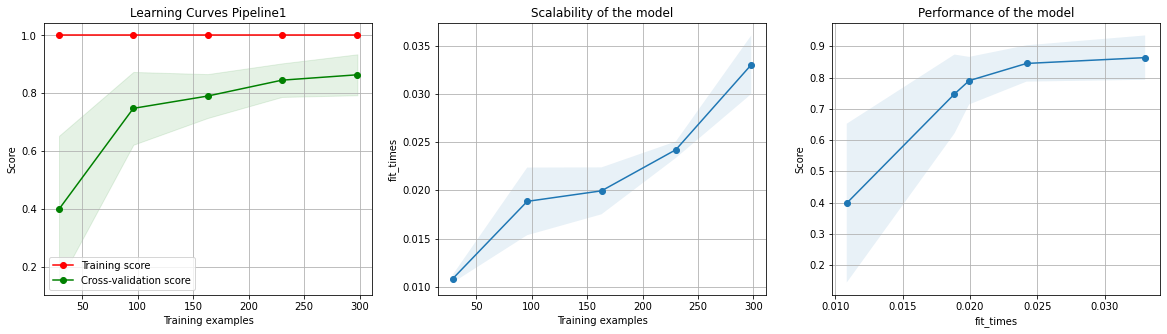

In [1509]:
# plot learning curces
# This cell can take upto 30 minutes to run
plc.plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves Pipeline1', X_train_cleaned, y_train, scoring=fbeta_scorer)
plt.show()

In [1510]:
print(f'Best cross-validation score: {halfgrid_classifier_1a.best_score_:.2f}')
print("\nBest parameters: ", halfgrid_classifier_1a.best_params_)
print("\nBest estimator: ", halfgrid_classifier_1a.best_estimator_)

Best cross-validation score: 0.82

Best parameters:  {'classifier__C': 100, 'vectorizer__max_features': 2000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=2000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=100, max_iter=10000))])


###<font color ='pickle'>**Evaluate model on test datset**

In [1511]:
# Final Pipeline
def final_pipeline(text):
  # cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  predictions = loaded_model_sparse_embed.predict(cleaned_text)
  return predictions

In [1512]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [1513]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.94      1.00      0.97       154
           1       1.00      0.70      0.82        30

    accuracy                           0.95       184
   macro avg       0.97      0.85      0.90       184
weighted avg       0.95      0.95      0.95       184



In [1514]:
print('F Beta Score for Test Set = ',fbeta_score(y_test, y_test_pred, beta=0.5))

F Beta Score for Test Set =  0.9210526315789475


## <font color='pickle'> **Q3.2 Pipeline 2: Data Preprocessing + Manual Features + ML Model pipeline**</font>

###<font color ='pickle'>**Preprocessing**

In [1515]:
featurizer =  ft.ManualFeatures(spacy_model='en_core_web_sm')

In [1516]:
X_train_features, feature_names  = featurizer.fit_transform(X_train)

In [1517]:
X_train_features[0:3]

array([[  2.        ,  22.        ,  19.        ,   9.5       ,
          0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   0.        ,   1.        ],
       [  5.        ,  23.        ,  19.        ,   3.8       ,
          0.        ,   0.        ,   0.        ,   3.        ,
          0.        ,   1.        ,   0.        ],
       [ 29.        , 139.        , 111.        ,   3.82758621,
          1.        ,   1.        ,   1.        ,   4.        ,
          3.        ,   4.        ,   3.        ]])

In [1518]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

### <font color ='pickle'>**Create Pipeline**

In [1519]:
classifier_1b = Pipeline([('classifier', LogisticRegression(max_iter = 10000)),
                        ])

### <font color ='pickle'>**Parameter Grid**

In [1520]:
# We have used default valus for all parameters except for lammetizer
# Ideally we can specify range of values for all parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1b = {'classifier__C': [0.01, 10, 1000, 100000]}

###<font color ='pickle'>**Apply HalvingGridSearch**

In [1521]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

halfgrid_classifier_1b = HalvingGridSearchCV(estimator=classifier_1b, param_grid=param_grid_classifier_1b, cv = 3, scoring=fbeta_scorer)

In [1522]:
# Fit the model on training data
halfgrid_classifier_1b.fit(X_train_features, y_train)

HalvingGridSearchCV(cv=3,
                    estimator=Pipeline(steps=[('classifier',
                                               LogisticRegression(max_iter=10000))]),
                    param_grid={'classifier__C': [0.01, 10, 1000, 100000]},
                    scoring=make_scorer(fbeta_score, beta=0.5))

### <font color ='pickle'>**Save Model**

In [1523]:
file_model_features = model_folder / 'features_model.pkl'

In [1524]:
joblib.dump(halfgrid_classifier_1b.best_estimator_, file_model_features)

['/content/drive/MyDrive/6342_NLP/models/features_model.pkl']

### <font color ='pickle'>**Load Model**

In [1525]:
# load the saved model
loaded_final_model_features = joblib.load(file_model_features)

### <font color ='pickle'>**Plot Learning Curve**


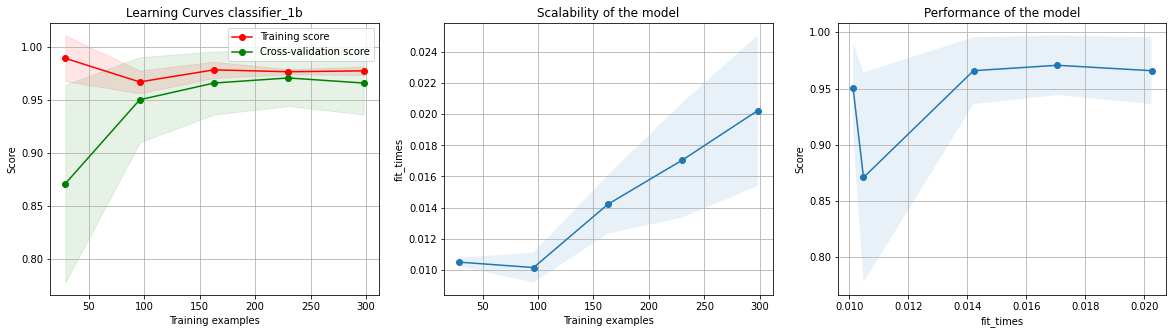

In [1526]:
# plot learning curces
# This cell can take upto 30 minutes to run
plc.plot_learning_curve(loaded_final_model_features, 'Learning Curves classifier_1b', X_train_features, y_train, scoring=fbeta_scorer)
plt.show()

In [1527]:
print("Best cross-validation score: {:.2f}".format(halfgrid_classifier_1b.best_score_))
print("\nBest parameters: ", halfgrid_classifier_1b.best_params_)
print("\nBest estimator: ", halfgrid_classifier_1b.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'classifier__C': 0.01}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=0.01, max_iter=10000))])


### <font color ='pickle'>**Evaluate model on test datset**

In [1528]:
# Final Pipeline
def final_pipeline(text):
  #cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  # cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  X_features, feature_names  = featurizer.fit_transform(text)
  # X_final = pd.concat((pd.DataFrame(cleaned_text, columns =['cleaned_text']), 
                          #  pd.DataFrame(X_features, columns=feature_names)),axis =1)
  X_final = pd.DataFrame(X_features, columns=feature_names)
  predictions = loaded_final_model_features.predict(X_final)
  return predictions

In [1529]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [1530]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      0.98      0.99       154
           1       0.91      0.97      0.94        30

    accuracy                           0.98       184
   macro avg       0.95      0.97      0.96       184
weighted avg       0.98      0.98      0.98       184



In [1531]:
print('F Beta Score for Test Set = ',fbeta_score(y_test, y_test_pred, beta=0.5))

F Beta Score for Test Set =  0.9177215189873417


## <font color ='pickle'>**Q3.3 Pipeline 3: Combine Manual Features and TfID vectors + ML Model**

### <font color ='pickle'>**Combine Manual Features and tfidf features**

<font color ='indianred'>**The approach described in this section is generic and can be used to combine any text (e.g. embeddings generated from text data) with non-text related variables**.

In [1532]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned, columns =['cleaned_text']), 
                           pd.DataFrame(X_train_features, columns=feature_names)),axis =1)

In [1533]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,s:)s.nervous lt;#&gt,2.0,22.0,19.0,9.500000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,got mail panren paru,5.0,23.0,19.0,3.800000,0.0,0.0,0.0,3.0,0.0,1.0,0.0
2,say right giggle see u possibly person2die nvq...,29.0,139.0,111.0,3.827586,1.0,1.0,1.0,4.0,3.0,4.0,3.0
3,haha awesome minute,7.0,33.0,27.0,3.857143,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,printer cool mean groovy wine groovye,9.0,47.0,39.0,4.333333,0.0,0.0,0.0,3.0,2.0,2.0,1.0


In [1534]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               373 non-null    object 
 1   count_words                373 non-null    float64
 2   count_characters           373 non-null    float64
 3   count_characters_no_space  373 non-null    float64
 4   avg_word_length            373 non-null    float64
 5   count_digits               373 non-null    float64
 6   count_numbers              373 non-null    float64
 7   noun_count                 373 non-null    float64
 8   aux_count                  373 non-null    float64
 9   verb_count                 373 non-null    float64
 10  adj_count                  373 non-null    float64
 11  ner                        373 non-null    float64
dtypes: float64(11), object(1)
memory usage: 35.1+ KB


In [1535]:
subset = X_train_final[0:30]

In [1536]:
subset.shape

(30, 12)

In [1537]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    
  def __init__(self):
    return None

  def fit(self, X, y=None):
      return self

  def transform(self, X, y=None):
      return csr_matrix(X)
 

In [1538]:
sparse_features = Pipeline([('sparse', SparseTransformer()),                     
                        ]) 
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)),                     
                        ]) 

In [1539]:
sparse_features.fit_transform(subset.iloc[:,1:])

<30x11 sparse matrix of type '<class 'numpy.float64'>'
	with 240 stored elements in Compressed Sparse Row format>

In [1540]:
vectorizer.fit_transform(subset.iloc[:,0])

<30x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [1541]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [1542]:
test = combined_features.fit_transform(subset)

In [1543]:
test.dtype

dtype('float64')

###<font color ='pickle'>**Create Final Pipeline**

In [1544]:
classifier_1c = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter = 10000)),
                        ])

In [1545]:
classifier_1c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

### <font color ='pickle'>**Parameter Grid**

In [1546]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV

param_grid_classifier_1c = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                            'classifier__C': [0.1, 1, 10, 1000, 100000]}

### <font color ='pickle'>**Apply HalvingGridSearch**

In [1547]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

halfgrid_classifier_1c = HalvingGridSearchCV(estimator=classifier_1c, param_grid=param_grid_classifier_1c, cv = 5, scoring=fbeta_scorer)

In [1548]:
# Fit the model on training data
halfgrid_classifier_1c.fit(X_train_final, y_train)

HalvingGridSearchCV(estimator=Pipeline(steps=[('combined_features',
                                               ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                            SparseTransformer())]),
                                                                 transformers=[('tfidf',
                                                                                Pipeline(steps=[('tfidf',
                                                                                                 TfidfVectorizer(max_features=5))]),
                                                                                'cleaned_text')])),
                                              ('classifier',
                                               LogisticRegression(max_iter=10000))]),
                    param_grid={'classifier__C': [0.1, 1, 10, 1000, 100000],
                                'combined_features__tfidf__tfi

In [1549]:
print("Best cross-validation score: {:.2f}".format(halfgrid_classifier_1c.best_score_))
print("\nBest parameters: ", halfgrid_classifier_1c.best_params_)
print("\nBest estimator: ", halfgrid_classifier_1c.best_estimator_)

Best cross-validation score: 0.93

Best parameters:  {'classifier__C': 1000, 'combined_features__tfidf__tfidf__max_features': 1000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=1000))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=1000, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [1550]:
file_model_combined = model_folder / 'combined_model.pkl'

In [1551]:
joblib.dump(halfgrid_classifier_1c.best_estimator_, file_model_combined)

['/content/drive/MyDrive/6342_NLP/models/combined_model.pkl']

### <font color ='pickle'>**Load Model**

In [1552]:
# load the saved model
loaded_model_combined = joblib.load(file_model_combined)

### <font color ='pickle'>**Plot Learning Curve**


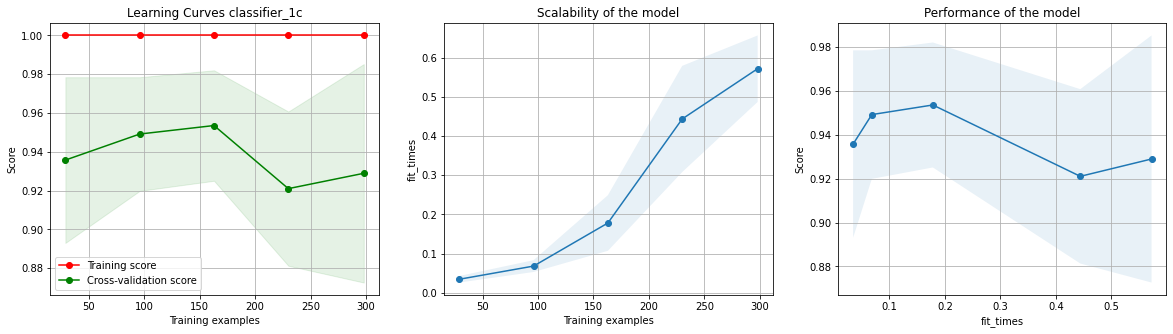

In [1553]:
# plot learning curves
plc.plot_learning_curve(loaded_model_combined, 'Learning Curves classifier_1c', X_train_final, y_train, scoring=fbeta_scorer)
plt.show()

<font color ='indianred'>**Observations**
<br></font>
Clearly there is <font color ='indianred'>**overfitting**</font>. In case of overfitting we can improve results by 

1. Adding more data (training model on complete dataset)
2. By hyperparameter tuning (reduce model complexity) of logistic regression and vectorizer.

In [1554]:
# Accuracy on Train data set
grid_classifier_combined = loaded_model_combined.score(X_train_final, y_train)
print(f'F Beta Score on train set  is {grid_classifier_combined}')

F Beta Score on train set  is 1.0


### <font color ='pickle'>**Evaluate model on test datset**

In [1555]:
X_test_cleaned = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(X_test)

In [1556]:
# save  this to a file
X_test_cleaned_sparse_embed = model_folder / 'x_test_cleaned_sparse_embed.pkl'

In [1557]:
joblib.dump(X_test_cleaned, X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/6342_NLP/models/x_test_cleaned_sparse_embed.pkl']

In [1558]:
# Final Pipeline
def final_pipeline(text):
  #cleaned_text = cp.SpacyPreprocessor(model = 'en_core_web_sm', remove_stop=True).transform(text)
  cleaned_text = joblib.load(X_test_cleaned_sparse_embed)
  X_features, feature_names  = featurizer.fit_transform(text)
  X_final = pd.concat((pd.DataFrame(cleaned_text, columns =['cleaned_text']), 
                           pd.DataFrame(X_features, columns=feature_names)),axis =1)
  
  predictions = loaded_model_combined.predict(X_final)
  return predictions

In [1559]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.
* This metric works very well in case of balanced as well as imbalanced data because it lets you measure the performance of model for each labels.

In [1560]:
print('\nTest set classification report:\n\n',classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       154
           1       0.94      1.00      0.97        30

    accuracy                           0.99       184
   macro avg       0.97      0.99      0.98       184
weighted avg       0.99      0.99      0.99       184



In [1561]:
print('F Beta Score for Test Set = ',fbeta_score(y_test, y_test_pred, beta=0.5))

F Beta Score for Test Set =  0.9493670886075949


# **Required Submissions:**
1.  Submit two colab/jupyter notebooks
- (analysis with smaller subset and all three pipelines)
- (analysis with bigger subset and only final pipeline)
2. Pdf version of the notebooks (HWs will not be graded if pdf version is not provided.
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw2, FirstName_file2_h2**